## Project : Unsupervised Learning 
## Submitted By : Kingshuk Banerjee

## Problem Statement

Background: AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

 

Objective: To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

 

Key Questions:

How many different segments of customers are there?

How are these segments different from each other?

What are your recommendations to the bank on how to better market to and service these customers?
 

Data Description: Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call.


Customer key - Identifier for the customer

Average Credit Limit - Average credit limit across all the credit cards

Total credit cards - Total number of credit cards

Total visits bank - Total number of bank visits

Total visits online - total number of online visits

Total calls made - Total number of calls made by the customer
 

Steps to follow: 

Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data. (10 marks)

Properly comment on the codes, provide explanations of the steps taken in the notebook and conclude your insights from the graphs. (5 marks)

Execute K-means clustering use elbow plot and analyse clusters using boxplot (10 marks)

Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot (15 marks)

Calculate average silhouette score for both methods. (5 marks)

Compare K-means clusters with Hierarchical clusters. (5 marks)

Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions. (10 marks)



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from scipy.stats import zscore


In [2]:
data = pd.read_excel('Credit Card Customer Data.xlsx')
data

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3
...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0


## Step 0: Exploration of the dataset and the columns
## ---------------------------------------------------------------------------------------------------------------------

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
Sl_No                  660 non-null int64
Customer Key           660 non-null int64
Avg_Credit_Limit       660 non-null int64
Total_Credit_Cards     660 non-null int64
Total_visits_bank      660 non-null int64
Total_visits_online    660 non-null int64
Total_calls_made       660 non-null int64
dtypes: int64(7)
memory usage: 36.2 KB


### All variables are int64 hence no need of datatype conversion. 
### Sl_No and Customer Key are not predictors of clusters, hence the below analysis is on rest of the columns.

In [4]:
data.iloc[:,2:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


### We can see that the Avg_Credit_Limit has a large range and possibly outliers since the max is way above the IQR. 
### But it will give us the required clustering information as customers can be segregated based on their credit limits.
### Total visits online and Total calls made are also showing some skew. 

### Leave the Sl No and Customer Key behind.

In [5]:
df = data.iloc[:,2:]
df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3
...,...,...,...,...,...
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0


In [6]:
df.nunique()

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

In [7]:
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### No indication of categorical variable (few unique values) or missing values

### Check any negative values

In [8]:
neg = False
for c in df.columns:
    if (any(df[c] < 0.0)):
        print("{} has negative values".format(c))
        neg = True
if (neg == False):
    print("There are no negative values.")

There are no negative values.


In [9]:
df.skew()

Avg_Credit_Limit       2.202396
Total_Credit_Cards     0.144879
Total_visits_bank      0.141896
Total_visits_online    2.225607
Total_calls_made       0.658905
dtype: float64

### As observed earlier, the Avg_Credit_Limit and Total_visits_online have heavy skews, indicating distinct segmnents of customers.
### Total_calls_made also has high skew, possibly highlighting one or more cluster attributes.

### Check if any customer data is repeated

In [11]:
data[data.duplicated()]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


In [10]:
data[data['Customer Key'].duplicated(keep=False)].sort_values('Customer Key')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


### Drop the duplicate records of same customer when the Avg_Credit_Limit is lower. This may indicate that the customer data is recaptured after increase in credit limit. 

In [12]:
data_unique = data.drop([48, 332, 411, 391, 104], axis=0)
data_unique.reset_index()
data_unique[data_unique['Customer Key'].duplicated(keep=False)].sort_values('Customer Key')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


In [13]:
df = data_unique.iloc[:, 2:]
data_unique[df.duplicated()]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,163,80457,8000,2,0,3,4
175,176,20524,6000,1,0,2,5
215,216,18609,8000,4,0,4,7
295,296,41380,10000,6,4,2,3
324,325,49844,9000,4,5,0,4
361,362,89635,18000,6,3,1,4
378,379,11398,12000,6,5,2,1
385,386,16418,8000,7,4,2,0
395,396,31515,5000,4,5,0,1
455,456,89446,47000,6,2,0,4


### Some customers have duplicated data from Avg_Credit_Limit through Total_Calls_made. This is possible and we will expect them to be in same cluster.
### As such duplicate data rows are not a problem in clustering, they may impact the average linkage, but since the customers are different, we cannot drop these rows.

## Step 1: Perform univariate analysis on the data to better understand the variables at your disposal and to get an idea about the no of clusters. Perform EDA, create visualizations to explore data.
## ---------------------------------------------------------------------------------------------------------------------

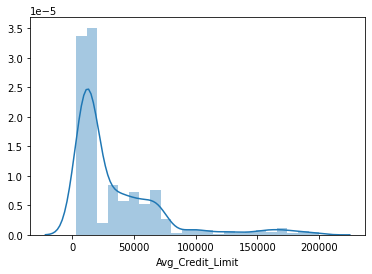

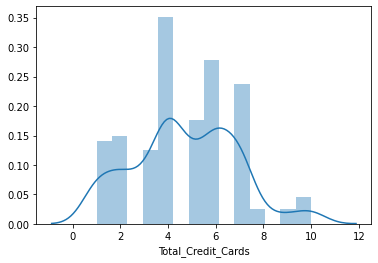

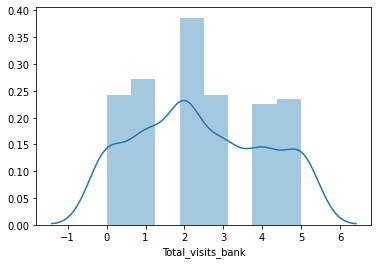

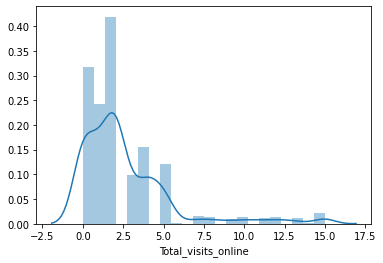

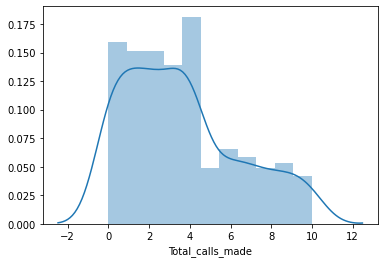

In [14]:
for col in df.columns:
    sns.distplot(df[col])
    plt.show()

### The plots show that there could be at least 3 or more clusters. 
### Total_Credit_Cards, Total_Visits_Bank and Total_visits_online are suggesting 3+ clusters. 
### Total_calls_made is indicating 2 clusters possibly. 

### Check for outliers

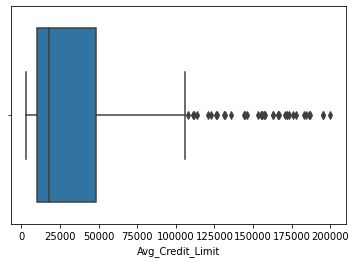

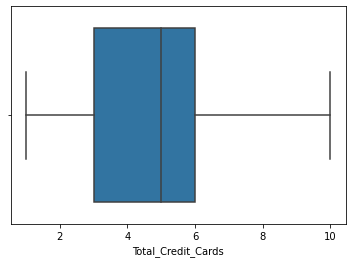

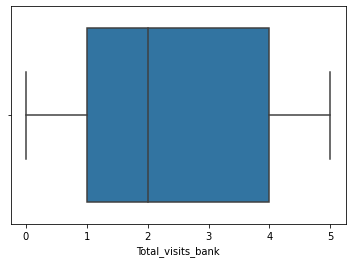

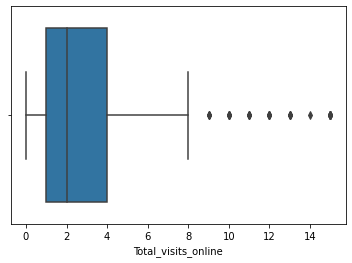

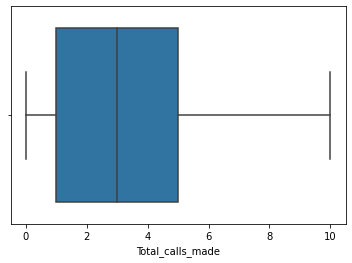

In [15]:
for c in df.columns:
    sns.boxplot(df[c])
    plt.show()

### The Avg_Credit_Limit and Total_visits_online have outliers. 
### However this is due to the customer profiles being different than other customers. 
### This should come out as different clusters as we guessed from the distribution plots too. 

### So let us leave the outliers as is and instead scale the data.
### We will try Manhattan distance after Euclidean distance to account for outliers better.

In [16]:
df_scaled = df.apply(zscore)
df_scaled.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.732369,-1.249105,-0.860646,-0.550400,-1.256040
1,0.406101,-0.788168,-1.475392,2.510549,1.901468
2,0.406101,1.055582,-0.860646,0.129811,0.147297
3,-0.124406,0.133707,-0.860646,-0.550400,0.147297
4,1.732369,0.594644,-1.475392,3.190759,-0.203537
5,-0.389659,-0.788168,-1.475392,-0.550400,1.550634
6,1.732369,0.133707,-1.475392,2.850654,-0.554372
7,-0.522286,-0.788168,-1.475392,-0.550400,-0.905206
8,-0.787540,-1.249105,-1.475392,-0.210294,-0.554372
9,-0.840590,-0.327230,-1.475392,-0.550400,1.199799


### Check the distribution on scaled data.

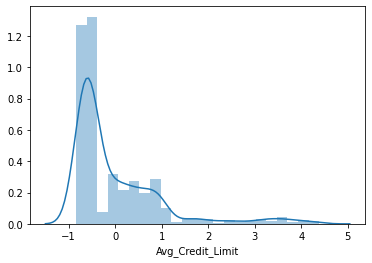

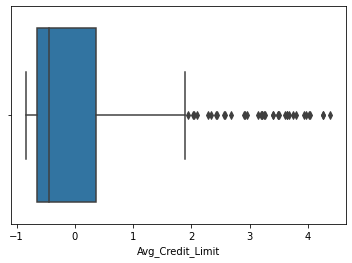

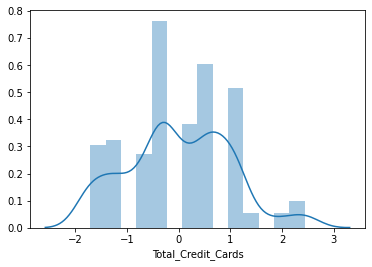

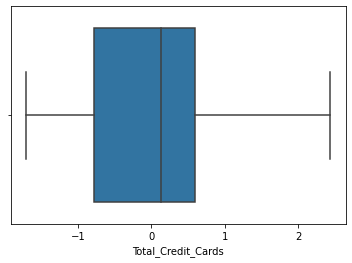

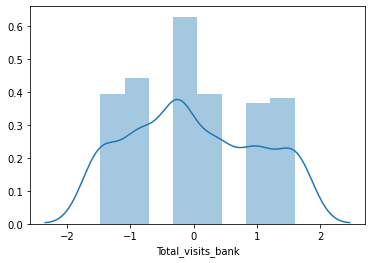

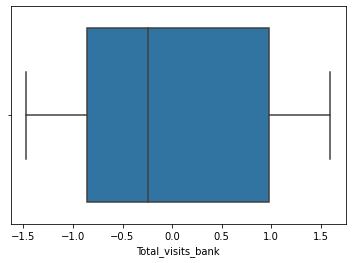

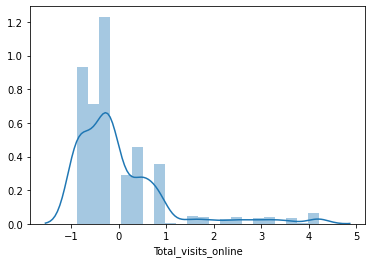

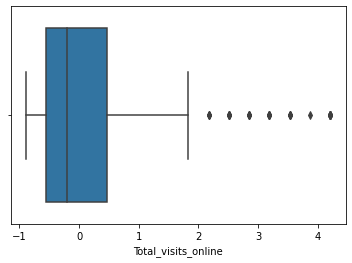

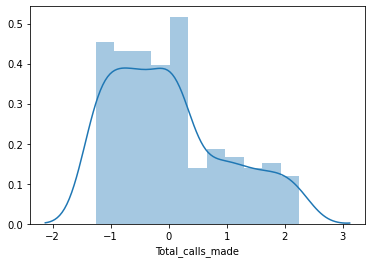

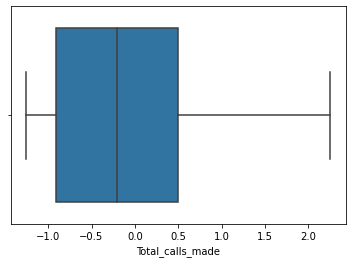

In [17]:
for col in df_scaled.columns:
    sns.distplot(df_scaled[col])
    plt.show()
    sns.boxplot(df_scaled[col])
    plt.show()

### Conclusion 
### On the scaled data too, the plots indicate 2 or 3 clusters.

## Step 2: Properly comment on the codes, provide explanations of the steps taken in the notebook and conclude your insights from the graphs.
## ---------------------------------------------------------------------------------------------------

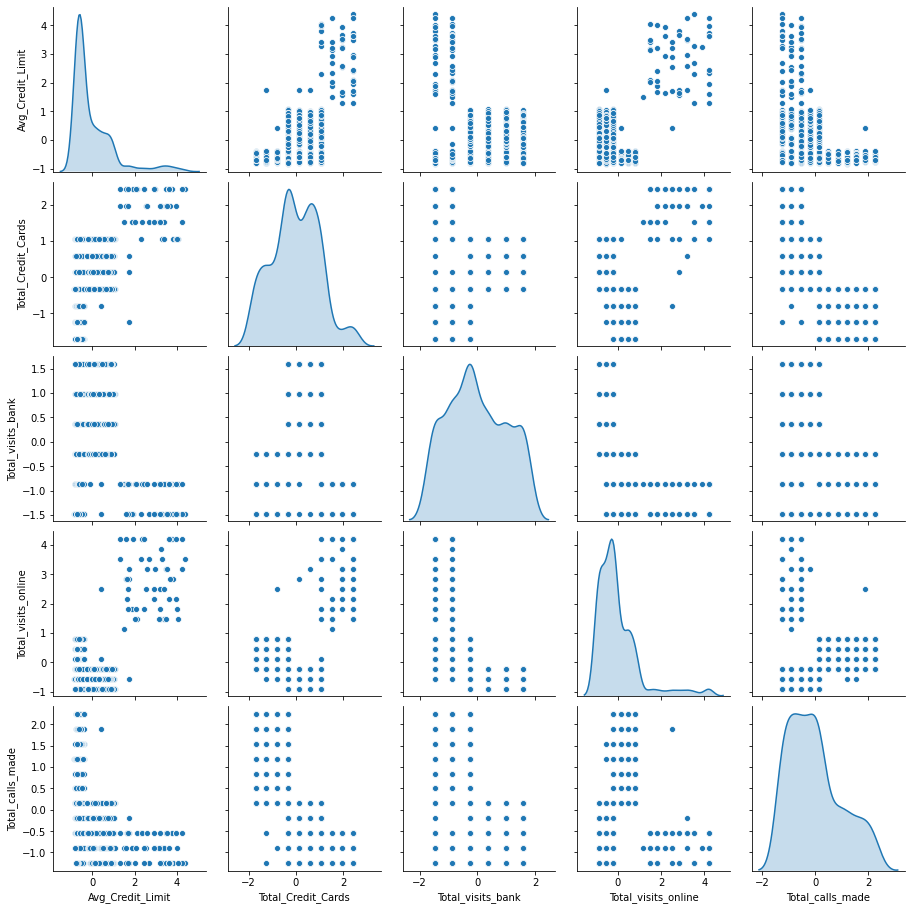

In [18]:
sns.pairplot(df_scaled, diag_kind='kde')

### There is not much correlation among the variables. 
### The distribution plots are showing presence of 3 or more clusters.

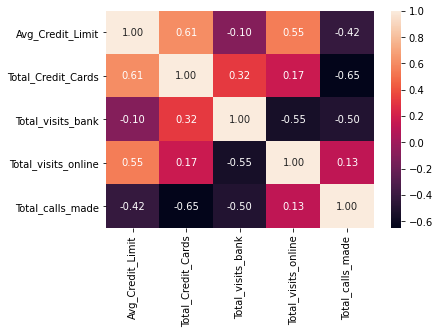

In [19]:
corr = df_scaled.corr()
sns.heatmap(corr, annot=True, fmt=".2f")

### These are some weaker correlations ( above abs(0.5) but not very high)
### 1. Total_Credit_Cards and Avg_Credit_Limit which is somewhat expected. 
### 2. Total_visits_online and Avg_Credit_Limit shows slight correlation, probably because people with higher credit limit are more tech-savvy.
### 3. Total_Credit_Cards and Total_calls_made are negatively correlated, probably because having more credit cards from the bank implies less issues. 
### 4. Total_visits_bank is negatively correlated to Total_visits_online and Total_calls_made, which is obvious. 

### Conclusions and insights from the graphs:
### From the analysis of the distribution and pair plots, 2 or 3 clusters are evident. 
### Some of the columns are correlated (though not very strongly) and will define the clusters.


## Step 3: Execute K-Means clustering, use elbow plot and analyse clusters using boxplots.
## ----------------------------------------------------------------------------------------

### Clustering - Try KMeans first for varied no. of clusters.

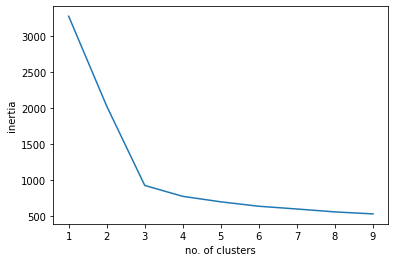

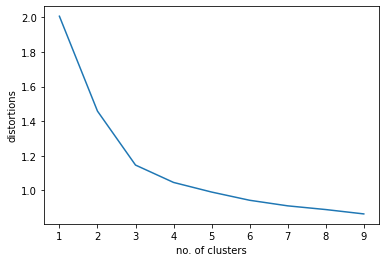

In [20]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

clusters = range(1, 10)
distances = []
meanDistortions = []

for c in clusters:
    model = KMeans(n_clusters=c)
    model.fit(df_scaled)
    prediction = model.predict(df_scaled)
    distances.append(model.inertia_)
    meanDistortions.append(sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])
#print(distances)
#print(meanDistortions)

plt.xlabel('no. of clusters')
plt.ylabel('inertia')
sns.lineplot(x=clusters, y=distances)
plt.show()
plt.xlabel('no. of clusters')
plt.ylabel('distortions')
sns.lineplot(x=clusters, y=meanDistortions)
plt.show()


### There is a clear elbow at n_clusters=3 with both graphs.
### clustering with n=3

In [24]:
model = KMeans(n_clusters=3, random_state=1)
model.fit(df_scaled)
clusters = model.predict(df_scaled)
data_unique['KMEANS_GROUP'] = clusters
df_grouped = df_scaled.copy()
df_grouped['KMEANS_GROUP'] = clusters
data_unique.head(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMEANS_GROUP
0,1,87073,100000,2,1,1,0,1
1,2,38414,50000,3,0,10,9,0
2,3,17341,50000,7,1,3,4,1
3,4,40496,30000,5,1,1,4,1
4,5,47437,100000,6,0,12,3,2
5,6,58634,20000,3,0,1,8,0
6,7,48370,100000,5,0,11,2,2
7,8,37376,15000,3,0,1,1,0
8,9,82490,5000,2,0,2,2,0
9,10,44770,3000,4,0,1,7,0


### Lets check if the duplicated data got same clusters or not.

In [25]:
dups = data_unique[df.duplicated(keep=False)]
dups.sort_values('Avg_Credit_Limit')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMEANS_GROUP
310,311,83459,5000,4,5,0,1,1
395,396,31515,5000,4,5,0,1,1
56,57,32828,6000,1,0,2,5,0
175,176,20524,6000,1,0,2,5,0
385,386,16418,8000,7,4,2,0,1
334,335,41159,8000,7,4,2,0,1
17,18,96463,8000,2,0,3,4,0
215,216,18609,8000,4,0,4,7,0
162,163,80457,8000,2,0,3,4,0
29,30,29112,8000,4,0,4,7,0


### Visually we can see that customers with same attributes got assigned the same cluster.

### Analyze the group characteristics via median and boxplot
### We chose median to get a clear picture of the attributes and to avoid effect of outliers.

In [26]:
data_unique.iloc[:,2:].groupby('KMEANS_GROUP').median()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KMEANS_GROUP,,,,,
0,12000,2,1,4,7
1,31000,6,3,1,2
2,145500,9,1,11,1


### From the median values of each group in the original data (not scaled), we can see the distinct ranges for each group. 
### Detailed analysis below. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a1c5f98>,
      dtype=object)

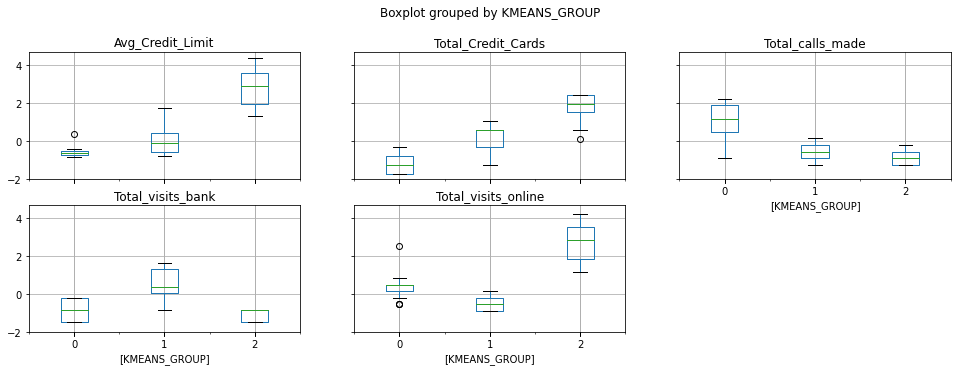

In [27]:
df_grouped.boxplot(by='KMEANS_GROUP', layout=(3, 3), figsize=(16,8))

### The Group Characteristics
### Group 0: 
#### 1. Has the least no. of credit cards and hence lower credit limit. 
#### 2. Calls the bank more often than the other groups. 
#### 3. This is the group that may have given the most feedback about the bank's support (callcenter) services.
#### 4. They visit the bank sometimes, often when their queries are not resolved by calls. 
#### 5. They also use the online services of the bank quite often. 
### This Group 0 seems to be the millenials (young customers) and still trying to figure out who to bank with. 
### Group 1: 
#### 1. These customers have a decent credit limit and manage 5-6 credit cards.
#### 2. They call the bank on certain issues but lesser than Group-0. 
#### 3. This group is fond of personal banking and often visits the branch. 
#### 4. They are also less tech savvy than the other groups, and hence online visits are less. 
### This Group 1 seems to stable long term customers who prefers the personal touch and will probably remain loyal to the bank.
### Group 2: 
#### 1. These customers have the highest no. of credit cards and high credit limits (4X than Group 1)
#### 2. They dont call the bank often and are probably already satisfied with this bank. 
#### 3. They also hardly visit the bank and hence are not looking for too much personal interaction. 
#### 4. They are highly tech-savvy and prefers to do their banking through the online channel. 
### This Group 2 seems to be the bank's High Net Worth Preferred customers. 

### The above classification based on the customers' interaction with the bank, segments the data into 3 distinct groups. 
### However the financial profiles of Group 0 and 1 customers are similar, with less credit cards and credit limit than Group 2.
### Group 2 seems to be very distinct than the other two. 


## Step 4: Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot.
## ------------------------------------------------------------------------------------------------------------
### Clustering using Hierarchical methods

### Agglomerative Clustering - Try the same no. of clusters as K-Means since that was based on elbow plot.

In [28]:
from sklearn.cluster import AgglomerativeClustering

In [31]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
# Remove the GROUP column from the scaled df
model.fit(df_scaled)
groups = model.labels_
data_unique['HIER_GROUP'] = groups
df_grouped = df_scaled.copy()
df_grouped['HIER_GROUP'] = groups
data_unique.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMEANS_GROUP,HIER_GROUP
0,1,87073,100000,2,1,1,0,1,0
1,2,38414,50000,3,0,10,9,0,2
2,3,17341,50000,7,1,3,4,1,0
3,4,40496,30000,5,1,1,4,1,2
4,5,47437,100000,6,0,12,3,2,1


### Do the group analysis using median and boxplots

In [32]:
data_unique.drop(['Sl_No', 'Customer Key'], axis=1).groupby('HIER_GROUP').median()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMEANS_GROUP
HIER_GROUP,,,,,,
0,31000,6,3,1,2,1
1,145500,9,1,11,1,2
2,12000,2,1,4,7,0


### We see similar grouping as KMeans. Only the group ids have changed - KMeans [0, 1, 2] is same as Agglomerative Cluster [2, 0, 1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b2e82b0>,
      dtype=object)

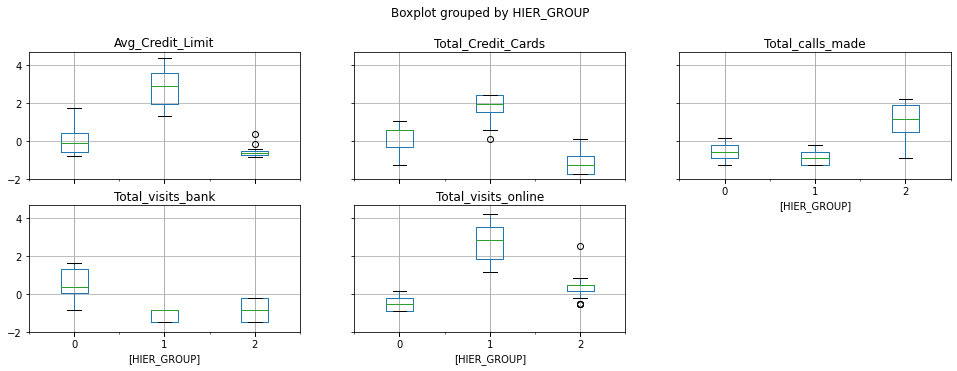

In [33]:
df_grouped.boxplot(by='HIER_GROUP', layout=(3, 3), figsize=(16,8))

### Comparing KMeans and Agglomerative Clustering using silhoutte score

In [34]:
from sklearn.metrics import silhouette_score

In [35]:
scores = dict()
scores['hierarchical'] = list()
scores['k-means'] = list()
kmeans_score = silhouette_score(df_scaled, clusters, metric='euclidean')
scores['k-means'].append(kmeans_score)
agglo_score = silhouette_score(df_scaled, groups, metric='euclidean')
scores['hierarchical'].append(agglo_score)
comp = pd.DataFrame.from_dict({'KMeans':[kmeans_score], 'Agglomerative': [agglo_score]}, orient='columns')
comp

,KMeans,Agglomerative
0,0.515466,0.515028


### This further proves that the two algorithms came up with almost identical clusters.
### However the silhoutte score is not very high, showing that there may be better clustering possible.
### Let us do the dendrogram analysis below.

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

def evaluate_linkage(data, metric='euclidean', method='average'):
    Z = linkage(data, metric=metric, method=method)
    c, dists = cophenet(Z, pdist(data))
    return Z, c

def plot_dendrogram(Z):
    plt.figure(figsize=(10, 5))
    plt.title('Agglomerative Hierarchical Clustering Dendogram')
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8., truncate_mode='lastp', p=5 )
    plt.tight_layout()

0.8971061215847376


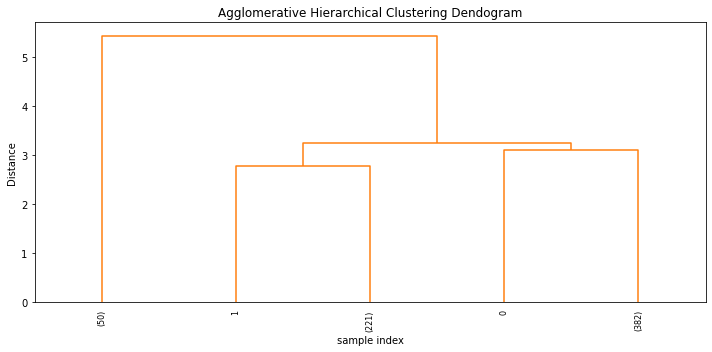

In [37]:
Z,c = evaluate_linkage(df_scaled)
print(c)
plot_dendrogram(Z)

### This confirms our previous observation that maybe two clusters are more prominent than 3. 

### Lets try some different linkages and find the best dendrogram based on cophenetic coefficient.

In [38]:
metrices = ['euclidean', 'cityblock', 'chebyshev', 'hamming']
methods = ['average', 'single', 'complete', 'centroid', 'weighted', 'ward', 'median']
best_c = -1
best_Z = None
best_params = None
table = dict()
table['metric'] = list()
table['method'] = list()
table['c_score'] = list()
for dist in metrices:
    for m in methods:
        if ((m == 'centroid' or m == 'ward' or m == 'median') and dist != 'euclidean'):
            continue
        Z, c = evaluate_linkage(df_scaled, dist, m)
        #print("metric = {} method = {} c = {}".format(dist, m, c))
        table['metric'].append(dist), table['method'].append(m), table['c_score'].append(c)
        if (c > best_c):
            best_c = c
            best_Z = Z
            best_params = (dist, m)
print("Best linkage obtained: c={} metric={} method={}".format(best_c, best_params[0], best_params[1]))
comp = pd.DataFrame.from_dict(table, orient='columns')
comp.sort_values('c_score', ascending=False)

Best linkage obtained: c=0.8971061215847376 metric=euclidean method=average


,metric,method,c_score
0,euclidean,average,0.897106
7,cityblock,average,0.895734
11,chebyshev,average,0.895208
3,euclidean,centroid,0.893873
10,cityblock,weighted,0.883776
6,euclidean,median,0.880840
2,euclidean,complete,0.875802
4,euclidean,weighted,0.874669
9,cityblock,complete,0.874453
13,chebyshev,complete,0.862621


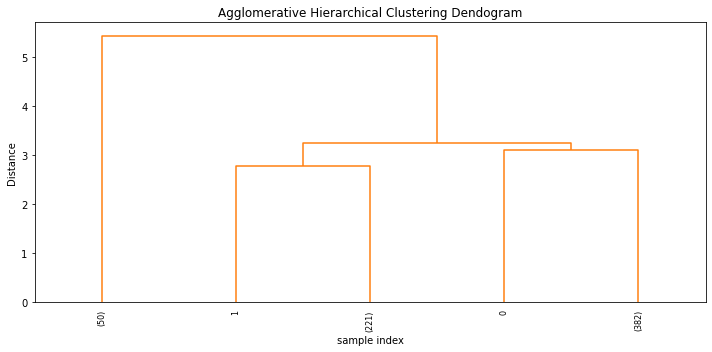

In [39]:
plot_dendrogram(best_Z)

### The best dendrogram shows that we could have 2 clusters as well. 

In [40]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
# Remove the GROUP column from the scaled df
model.fit(df_scaled)
groups = model.labels_
data_unique['DENDRO_GROUP'] = groups
df_grouped = df_scaled.copy()
df_grouped['DENDRO_GROUP'] = groups
data_unique.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMEANS_GROUP,HIER_GROUP,DENDRO_GROUP
0,1,87073,100000,2,1,1,0,1,0,0
1,2,38414,50000,3,0,10,9,0,2,0
2,3,17341,50000,7,1,3,4,1,0,0
3,4,40496,30000,5,1,1,4,1,2,0
4,5,47437,100000,6,0,12,3,2,1,1


In [41]:
agglo_score = silhouette_score(df_scaled, groups, metric='euclidean')
scores['hierarchical'].append(agglo_score)
agglo_score

0.5696856963894219

In [42]:
model = KMeans(n_clusters=2)
model.fit(df_scaled)
clusters = model.predict(df_scaled)
kmeans_score = silhouette_score(df_scaled, clusters, metric='euclidean')
scores['k-means'].append(kmeans_score)
kmeans_score

0.41772421031246804

## Observation
### Agglomerative clustering does a better score for 2 clusters than 3 clusters. 
### KMeans score degrades for 2 clusters, and thus 3 clusters are better in K-Means.

In [43]:
data_unique.drop(['Sl_No', 'Customer Key', 'KMEANS_GROUP', 'HIER_GROUP'], axis=1).groupby('DENDRO_GROUP').median()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
DENDRO_GROUP,,,,,
0,17000,4,2,2,3
1,145500,9,1,11,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b77eeb8>,
      dtype=object)

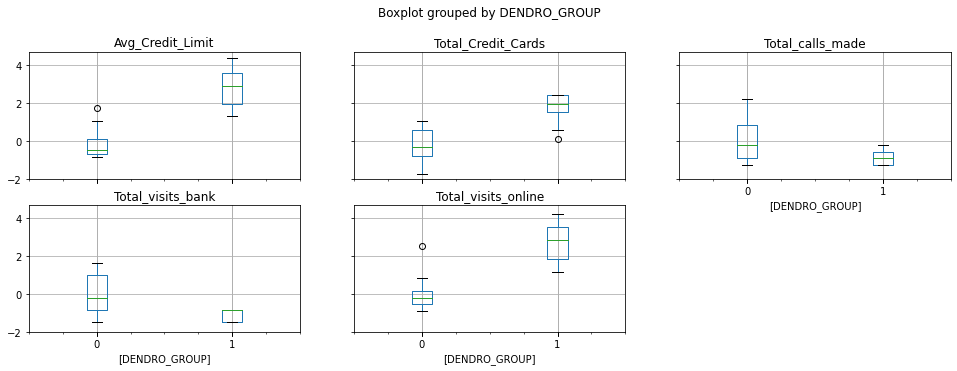

In [44]:
df_grouped.boxplot(by='DENDRO_GROUP', layout=(3, 3), figsize=(16,8))

### From the boxplots and median analysis of the groups, we can see that the first two groups (found from KMeans) have been merged into one cluster.
### The High Net worth customers are distinctly in the second group - with higher credit limit, no. of cards and more online profile than calls/visits.

## Step 5: Calculate average silhoutte score for both methods. 
## Step 6: Compare K-Means clusters with Hierarchical clusters.
## ------------------------------------------------------------

### Silhouttes scores were calculated for both methods earlier and for 2 and 3 clusters. 
### Below we are summarizing the comparison.

In [45]:
scores_df = pd.DataFrame.from_dict(scores, orient='index', columns=['n_clusters=3', 'n_clusters=2'])
print(scores_df)

              n_clusters=3  n_clusters=2
hierarchical      0.515028      0.569686
k-means           0.515466      0.417724


### The score comparisons show that KMeans performed better with 3 clusters, whereas Hierarchical clusters is better for 2 than 3. 
### And from the dendrogram it seems that Hierarchical clustering suggested 2 distinct clusters. 
### For K-Means, the elbow plot on the other hand suggested 3 clusters.

### K-Means clusters segmented the customers into 3 groups, as we have explained before. 
###        1. Millenials
###        2. Stable and mid-range customers
###        3. High Net worth customers
### Whereas Hierarchical clusters segmented the customers into 2 prominent groups as described above using boxplots and median table.
###        1. Regular customers
###        2. Premium or High Net worth customers

## Step 7: Analyze the clusters formed, tell us how is one cluster different from another and answer all the key questions.
## -----------------------------------------------------------------------------------------------------

## Answering Key Questions
## How many different segments of customers are there?
### There are 3 segments of customers of the bank. However the Groups 0 and 1 are closer than Group 2. 
### This is the reason KMeans identifies 3 groups but Hierarchical clustering (Best dendrogram) indicates 2 distinct groups.
### Depending on which department (Marketing or Delivery) is using the information, the customers can be segmented into 2 or 3 segments.

In [46]:
data_unique.drop(['Sl_No', 'Customer Key', 'HIER_GROUP', 'DENDRO_GROUP'], axis=1).groupby('KMEANS_GROUP').median()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KMEANS_GROUP,,,,,
0,12000,2,1,4,7
1,31000,6,3,1,2
2,145500,9,1,11,1


In [47]:
data_unique.drop(['Sl_No', 'Customer Key', 'HIER_GROUP', 'KMEANS_GROUP'], axis=1).groupby('DENDRO_GROUP').median()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
DENDRO_GROUP,,,,,
0,17000,4,2,2,3
1,145500,9,1,11,1


## How are these segments different from each other?
### The 3 segments are different in two aspects, financial profile and the nature of their interaction with the bank. 
### Group 0: 
###    -  Financial Profile : Less no. of credit cards (2) and lower credit limit (12000). Young or not fully committed to the bank yet.
###    - Interaction : High no. of calls made to the bank, less visits and online otherwise. Has more issues with support.
### Group 1: 
###    - Financial Profile : Average no. of credit cards (6) and decent credit limit (30000). Financially stable, loyal to the bank but not high net worth.
###    - Interaction : Less online, occasionally calls and prefers visiting the bank branches more often. Prefers personal service, face to face.
### Group 2: 
###    - Financial Profile : High credit limit (145500) and maintains lots of credit cards (9). Very distinct than the other two groups, High Net Worth customers.
###    - Interaction : Do not have time or inclination to visit or call the bank. Uses online banking extensively. Tech savvy and busy executives. 
### The Group-0 and Group-1 customers can also be merged into one Segment (Regular) and Group-2 as another (Preferred/Premium) segment. 

## What are your recommendations to the bank on how to better market to and service these customers?
### Based on the K-Means and Hierarchical clustering, we will create two different segmentation of the data set. 
### One will use 2 segments and can be used by Marketing Head/Dept. 
### Another one will use 3 segments and can be used by Service Head/Dept. 
### More explanation below.

In [48]:
marketing = data_unique.drop(['HIER_GROUP', 'KMEANS_GROUP'], axis=1)
marketing = marketing.rename({'DENDRO_GROUP':'MARKET_SEGMENT'}, axis=1)
marketing['MARKET_SEGMENT'] = marketing['MARKET_SEGMENT'].apply(lambda x: 'Regular' if x == 0 else 'Premium')
marketing

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,MARKET_SEGMENT
0,1,87073,100000,2,1,1,0,Regular
1,2,38414,50000,3,0,10,9,Regular
2,3,17341,50000,7,1,3,4,Regular
3,4,40496,30000,5,1,1,4,Regular
4,5,47437,100000,6,0,12,3,Premium
...,...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0,Premium
656,657,60732,84000,10,1,13,2,Premium
657,658,53834,145000,8,1,9,1,Premium
658,659,80655,172000,10,1,15,0,Premium


In [49]:
marketing['MARKET_SEGMENT'].value_counts()

Regular    605
Premium     50
Name: MARKET_SEGMENT, dtype: int64

### The Marketing Head can look at above two segments, Regular and Premium for upselling products. 
###    - The Regular customers can be sold more high end products to bring them to the Premium level. 
###    - The Regular customers' interaction (phone and visits) can be used to upsell or sell customized credit solutions.
###    - The Premium customers on the other hand, can be targeted through online marketing towards higher end sophisticated financial products (wealth management, mortgages etc.)
###    - The no. of Premium customers is much less (1/12) compared to Regular customers. 
###      Hence Marketing should focus on upgrading more Regular customers to Premium through up-selling of credit cards and credit limit.

In [50]:
service = data_unique.drop(['HIER_GROUP', 'DENDRO_GROUP'], axis=1)
service = service.rename({'KMEANS_GROUP':'SERVICE_TYPE'}, axis=1)
service['SERVICE_TYPE'] = service['SERVICE_TYPE'].apply(lambda x: 'Calling' if x == 0 else "Visting" if x == 1 else "Online")
service

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,SERVICE_TYPE
0,1,87073,100000,2,1,1,0,Visting
1,2,38414,50000,3,0,10,9,Calling
2,3,17341,50000,7,1,3,4,Visting
3,4,40496,30000,5,1,1,4,Visting
4,5,47437,100000,6,0,12,3,Online
...,...,...,...,...,...,...,...,...
655,656,51108,99000,10,1,10,0,Online
656,657,60732,84000,10,1,13,2,Online
657,658,53834,145000,8,1,9,1,Online
658,659,80655,172000,10,1,15,0,Online


In [51]:
service['SERVICE_TYPE'].value_counts()

Visting    383
Calling    222
Online      50
Name: SERVICE_TYPE, dtype: int64

### The Delivery (Support) Head can look at the three segments, Callers, Visitors and Online. 
###    - The Caller group of customers calls the most, and have given feedback about the poor support of the call center. 
###    - These customers can be contacted individually and their pending issues be resolved.
###    - The Visitor customers visit the bank often. The service level to them can be improved by training the staff to be courteous and reducing wait times. 
###    - These customers can also be randomly contacted/interviewed by the Support team to collect on-the-spot feedback about the bank's services.
###    - The High-networth Online customers seem to have less issues with the bank's support services.
###    - However it is important to make sure that they are constantly delighted by the online experience and the ease of banking.
###    - Keeping in mind the high end relationship and expectations, the service team will have to work with the technical team to provide a quick and efficient online banking. 